In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mirichoi0218/insurance

insurance.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
! unzip insurance.zip

Archive:  insurance.zip
replace insurance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install -U scikit-learn
import sklearn; print("Scikit-Learn", sklearn.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Scikit-Learn 1.2.2


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
data=pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [8]:
data.columns[data.isnull().any()]

Index([], dtype='object')

Data Visualization

(array([6.84770002e-05, 5.94103591e-05, 4.89121430e-05, 4.60489932e-05,
        1.69403032e-05, 1.38385575e-05, 1.09754077e-05, 9.54383278e-06,
        5.96489549e-06, 2.38595820e-06, 5.96489549e-06, 8.11225786e-06,
        7.15787459e-06, 6.44208713e-06, 5.24910803e-06, 2.38595820e-06,
        2.38595820e-07, 2.38595820e-07, 4.77191639e-07, 4.77191639e-07]),
 array([ 1121.8739   ,  4254.3016055,  7386.729311 , 10519.1570165,
        13651.584722 , 16784.0124275, 19916.440133 , 23048.8678385,
        26181.295544 , 29313.7232495, 32446.150955 , 35578.5786605,
        38711.006366 , 41843.4340715, 44975.861777 , 48108.2894825,
        51240.717188 , 54373.1448935, 57505.572599 , 60638.0003045,
        63770.42801  ]),
 <BarContainer object of 20 artists>)

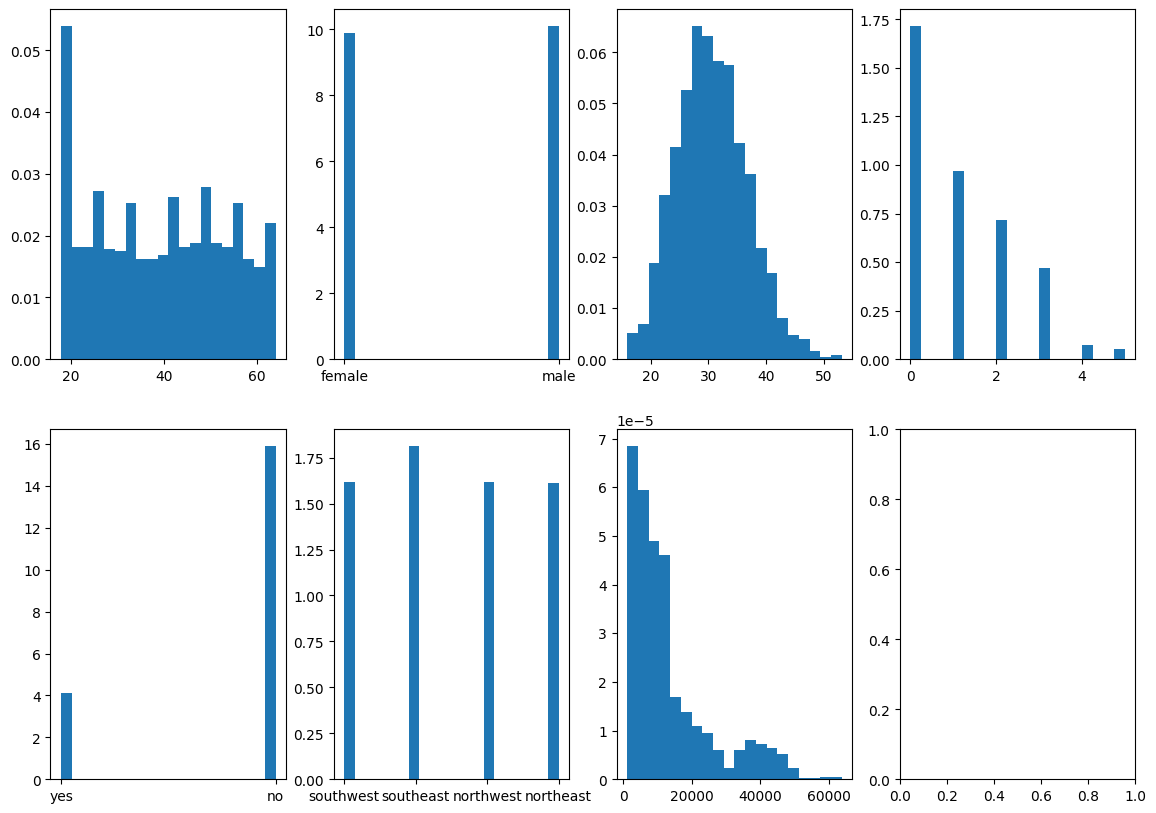

In [9]:
fig, ax = plt.subplots(2,4, figsize=(14,10))
n_bins=20
ax[0,0].hist(data['age'],n_bins, density=True)
ax[0,1].hist(data['sex'],n_bins, density=True)
ax[0,2].hist(data['bmi'],n_bins, density=True)
ax[0,3].hist(data['children'],n_bins, density=True)
ax[1,0].hist(data['smoker'],n_bins, density=True)
ax[1,1].hist(data['region'],n_bins, density=True)
ax[1,2].hist(data['charges'],n_bins, density=True)
# ax[1,3].hist(data['totChol'],n_bins, density=True)

In [10]:
# fig, ax = plt.subplots(2,4, figsize=(14,10))
# i=0
# j=0
# a=0
# n_bins=20
# while (a<7):
#   while (j<4):
#     while(i<2):
#       ax[i,j].hist(data[data.columns[a]],n_bins, density=True)
#       j++
#       a++



{'whiskers': [<matplotlib.lines.Line2D at 0x7f92116d2d70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f92116d3190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f92116d2ad0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f92116d36d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f92116d3970>,
 'means': []}

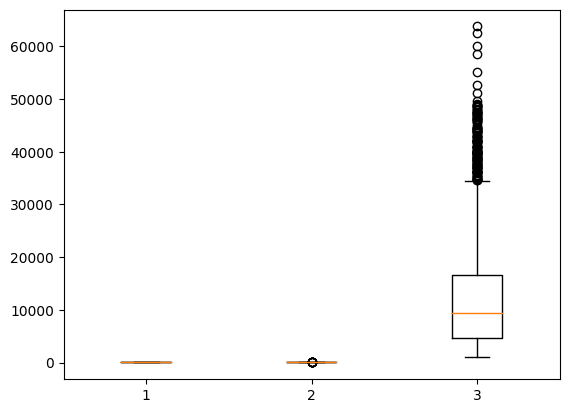

In [11]:
data_numeric= data[['age','bmi','charges']]
plt.boxplot(data_numeric)

In [12]:
from scipy.stats.mstats import normaltest
print(normaltest(data.age.values))
print(normaltest(data.bmi.values))
print(normaltest(data.charges.values))

NormaltestResult(statistic=1557.8205812363667, pvalue=0.0)
NormaltestResult(statistic=17.581447872784118, pvalue=0.0001521377897266011)
NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)


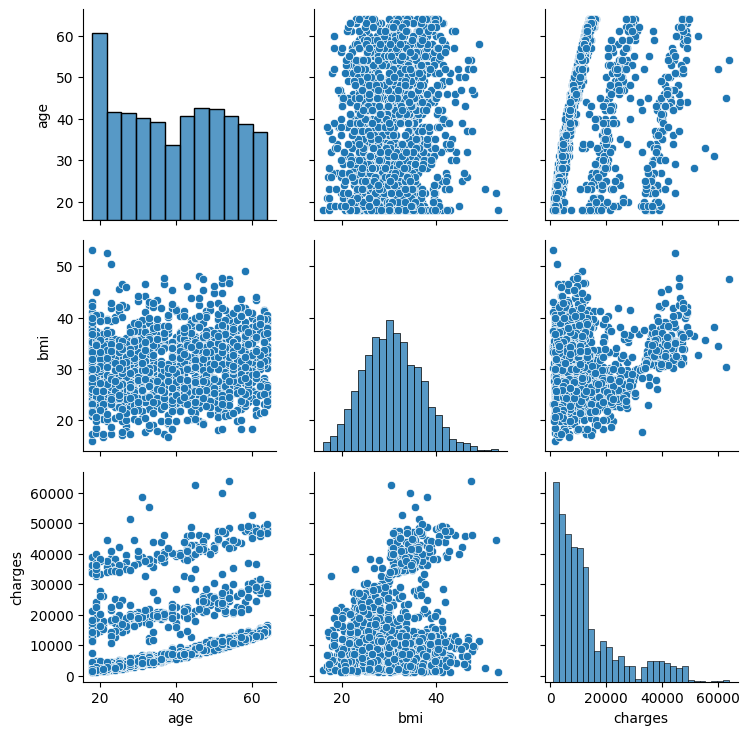

In [13]:
import seaborn as sns
g = sns.PairGrid(data_numeric)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [14]:
print(data['age'].skew())
print(data['bmi'].skew())
print(data['charges'].skew())

0.05567251565299186
0.2840471105987448
1.5158796580240388


In [15]:
# Create a list of float colums to check for skewing
mask = data.dtypes == np.float
float_cols = data.columns[mask]

In [16]:
skew_limit = 0.75
skew_vals = data.skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
charges,1.51588
children,0.93838


Feature transformation

NormaltestResult(statistic=52.71670509113935, pvalue=3.5703676381337117e-12)
<class 'pandas.core.series.Series'>
-0.09009752473024582


,age,sex,bmi,children,smoker,region,charges,charges_log
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


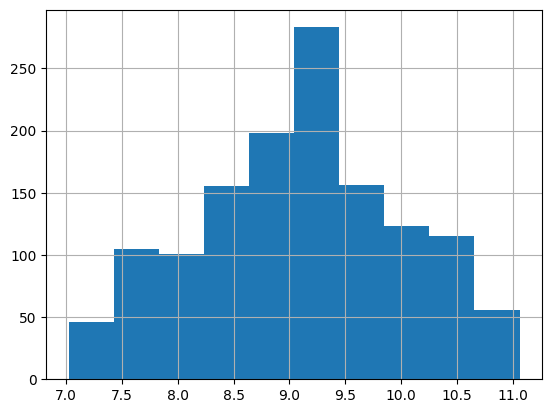

In [17]:
log_charges = np.log(data.charges)
log_charges.hist()
print(normaltest(log_charges))
print(type(log_charges))
print(log_charges.skew())
data['charges_log']=log_charges
data.head()

In [18]:
# sqrt_charges = np.sqrt(data.charges)
# sqrt_charges.hist()
# print(normaltest(sqrt_charges))
# print(type(sqrt_charges))
# print(sqrt_charges.skew())
# data['charges_sqrt']=sqrt_charges


In [19]:
# from scipy.stats import boxcox
# bc_result = boxcox(data.charges)
# boxcox_charges = bc_result[0]
# lam = bc_result[1]

In [20]:
# data['charges'].hist()
# plt.hist(boxcox_charges)
# print(normaltest(boxcox_charges))
# print(type(boxcox_charges))
# print(boxcox_charges.skew())

Calculate the $R^{2}$ on each feature given the a input model.


In [21]:
def get_R2_features(model,test=True):
    #X: global
    features=list(X)
    # features.remove("three")

    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)

        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))

    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

The function below will plot the distribution of two inputs.


In [22]:
def  plot_dis(y,yhat):

    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

Plot coef and R2

In [23]:
def plot_coef(X,model,name=None):

    plt.bar(X.columns[2:],abs(model.coef_[2:]))
    plt.xticks(rotation=90)
    plt.ylabel("$coefficients$")
    plt.title(name)
    plt.show()
    print("R^2 on training  data ",model.score(X_train, y_train))
    print("R^2 on testing data ",model.score(X_test,y_test))

Label Encoding

In [24]:
## Label encoding column A of our dataset
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

data_labelencode=data
# Encode labels in column 'species'.
data_labelencode['smoker']= label_encoder.fit_transform(data_labelencode['smoker'])
data_labelencode['sex']= label_encoder.fit_transform(data_labelencode['sex'])
data_labelencode['region']= label_encoder.fit_transform(data_labelencode['region'])

data_labelencode.head()

,age,sex,bmi,children,smoker,region,charges,charges_log
0,19,0,27.900,0,1,3,16884.92400,9.734176
1,18,1,33.770,1,0,2,1725.55230,7.453302
2,28,1,33.000,3,0,2,4449.46200,8.400538
3,33,1,22.705,0,0,1,21984.47061,9.998092
4,32,1,28.880,0,0,1,3866.85520,8.260197


In [25]:
data_onehotencode = pd.get_dummies(data, columns = ['sex'])
data_onehotencode = pd.get_dummies(data_onehotencode, columns = ['smoker'])
data_onehotencode = pd.get_dummies(data_onehotencode, columns = ['region'])
data_onehotencode.head()

,age,bmi,children,charges,charges_log,sex_0,sex_1,smoker_0,smoker_1,region_0,region_1,region_2,region_3
0,19,27.900,0,16884.92400,9.734176,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,7.453302,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,8.400538,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,9.998092,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,8.260197,0,1,1,0,0,1,0,0


In [26]:
data= data_labelencode
# data= data_onehotencode

Outliers

In [27]:
from scipy import stats
z= np.abs(stats.zscore(data.bmi))
threshold=3
print(np.where(z>threshold))
data=data[(z<3)]

(array([ 116,  847, 1047, 1317]),)


Feature Scaling

In [28]:
data=data.drop(columns=['charges'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f92119941c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9211994700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f921195bee0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9211994c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9211994ee0>,
 'means': []}

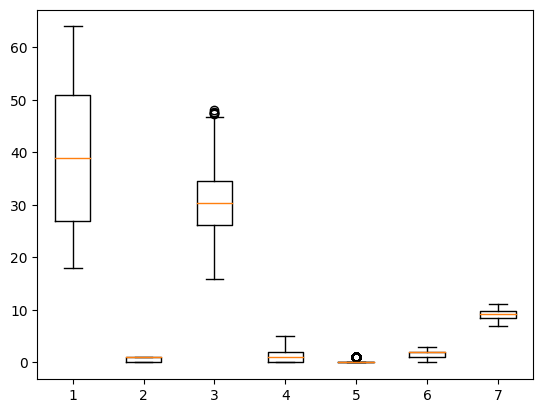

In [29]:
plt.boxplot(data)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
sns.boxplot(scaled_df)

In [31]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# scaled_data = scaler.fit_transform(data)
# scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
# sns.boxplot(scaled_df)

Data correlation

In [32]:
data= scaled_df

In [33]:
data.rename(columns = {'charges_log':'charges'}, inplace = True)

In [34]:
corr_matrix = data.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.665312
age         0.528794
children    0.160729
bmi         0.139883
sex         0.006873
region     -0.042327
Name: charges, dtype: float64

Linearity assumption

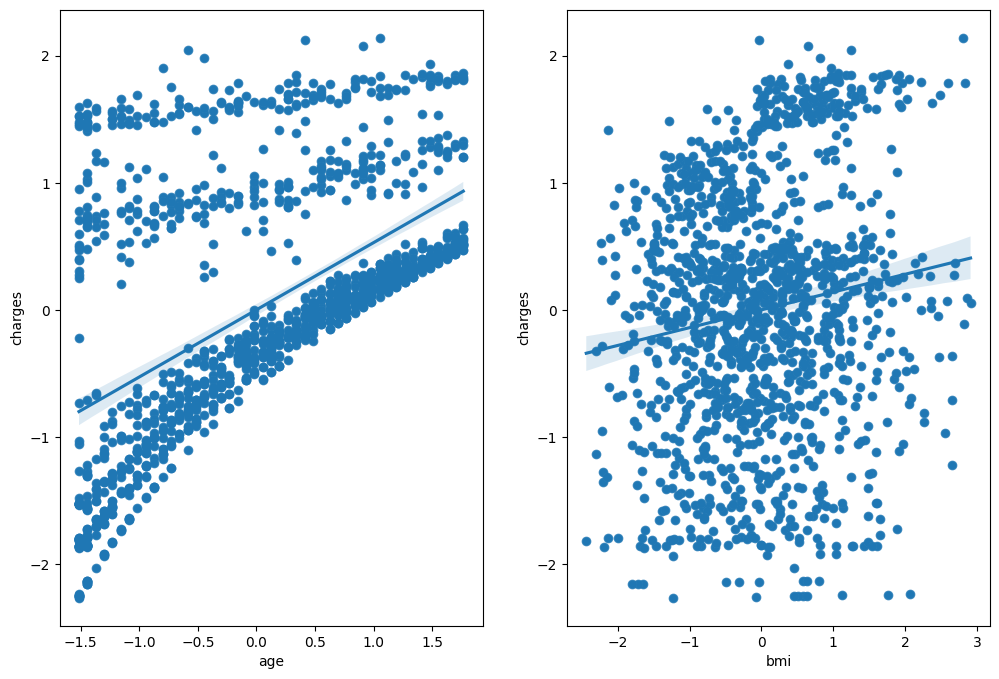

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
sns.scatterplot( x = data.age, y = data.charges,  ax=ax1)
sns.regplot(x=data.age, y=data.charges, ax=ax1)

sns.scatterplot(x = data.bmi,y = data.charges, ax=ax2)
sns.regplot(x=data.bmi, y=data.charges, ax=ax2);


<Axes: xlabel='bmi', ylabel='charges'>

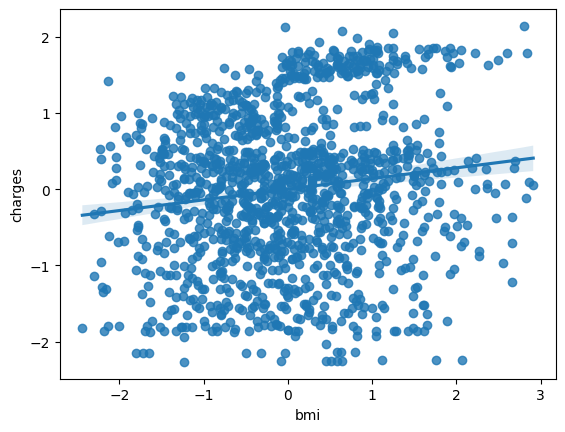

In [36]:
sns.regplot(x=data.bmi, y=data.charges, data=data)

Homoscedasticity
(constant variance)

<Axes: xlabel='age', ylabel='charges'>

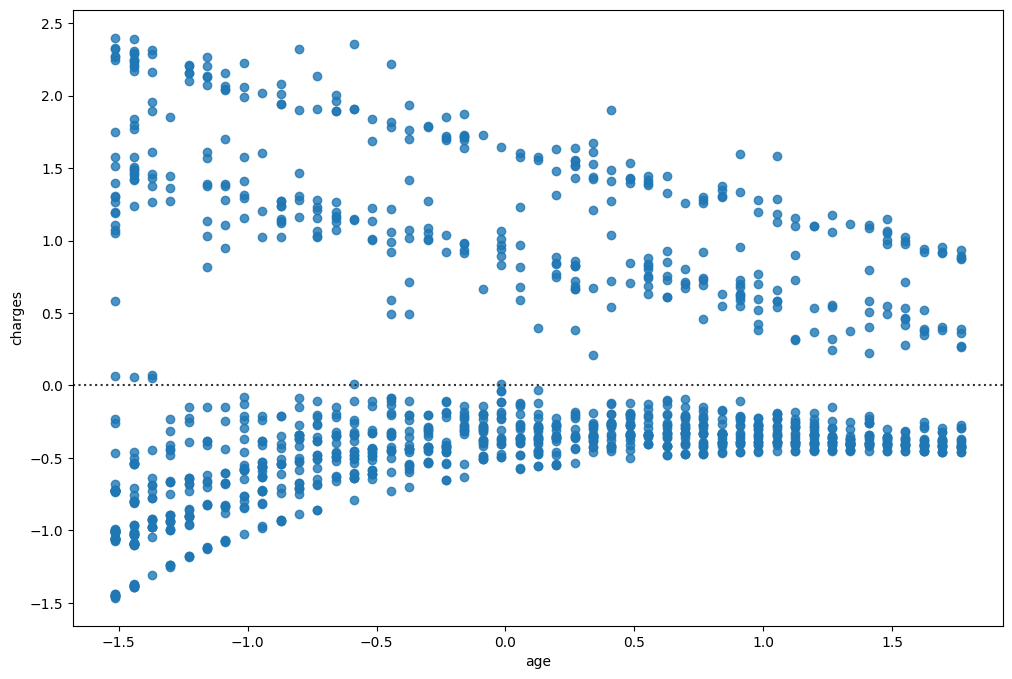

In [37]:
plt.subplots(figsize = (12,8))
sns.residplot(data=data, x="age", y="charges")

Normality

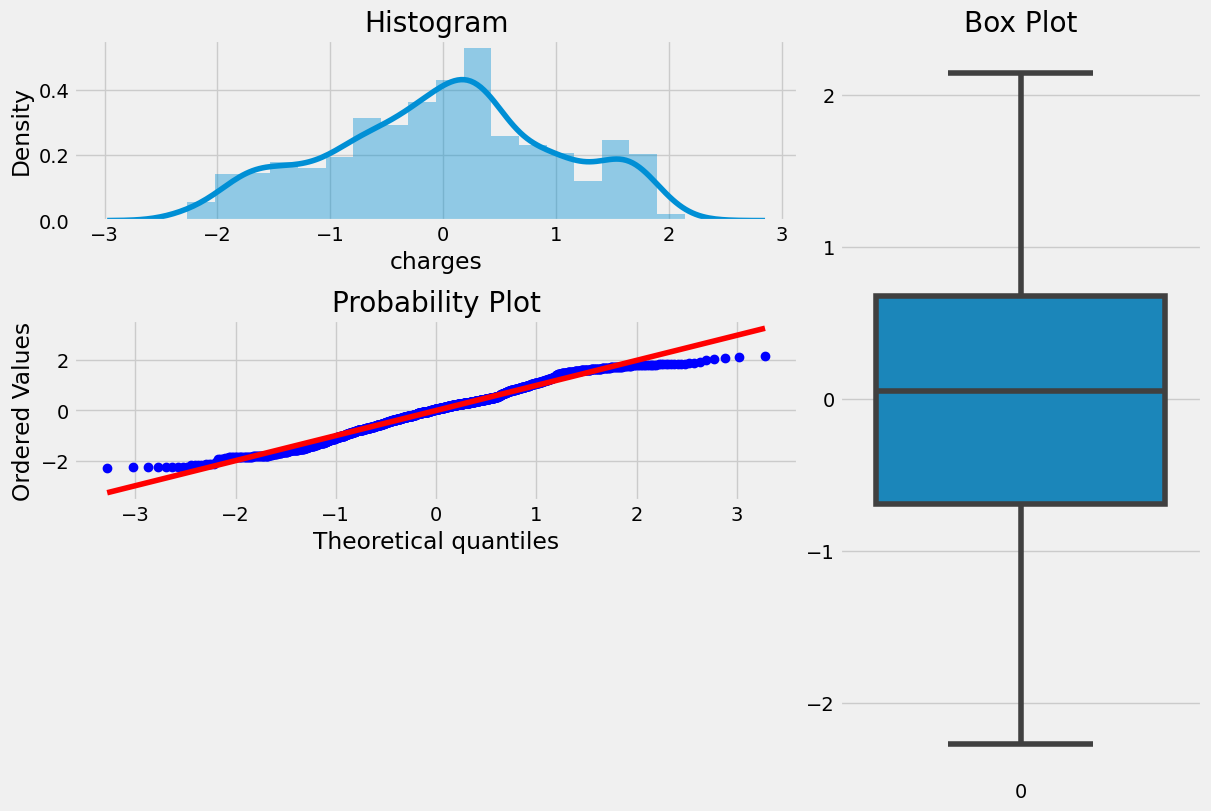

In [38]:
def plotting_3_chart(data, feature):
    ## Importing seaborn, matplotlab and scipy modules.
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title.
    ax1.set_title('Histogram')
    ## plot the histogram.
    sns.distplot(data.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title.
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot.
    stats.probplot(data.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title.
    ax3.set_title('Box Plot')
    ## Plotting the box plot.
    sns.boxplot(data.loc[:,feature], orient='v', ax = ax3);

plotting_3_chart(data, 'charges')

In [39]:
normaltest(data.charges.values)

NormaltestResult(statistic=52.30566485311105, pvalue=4.384995893663747e-12)

In [40]:
data['charges'].skew()

-0.0882952250634557

Multicollinearity
(strong correlation between the independent variables)

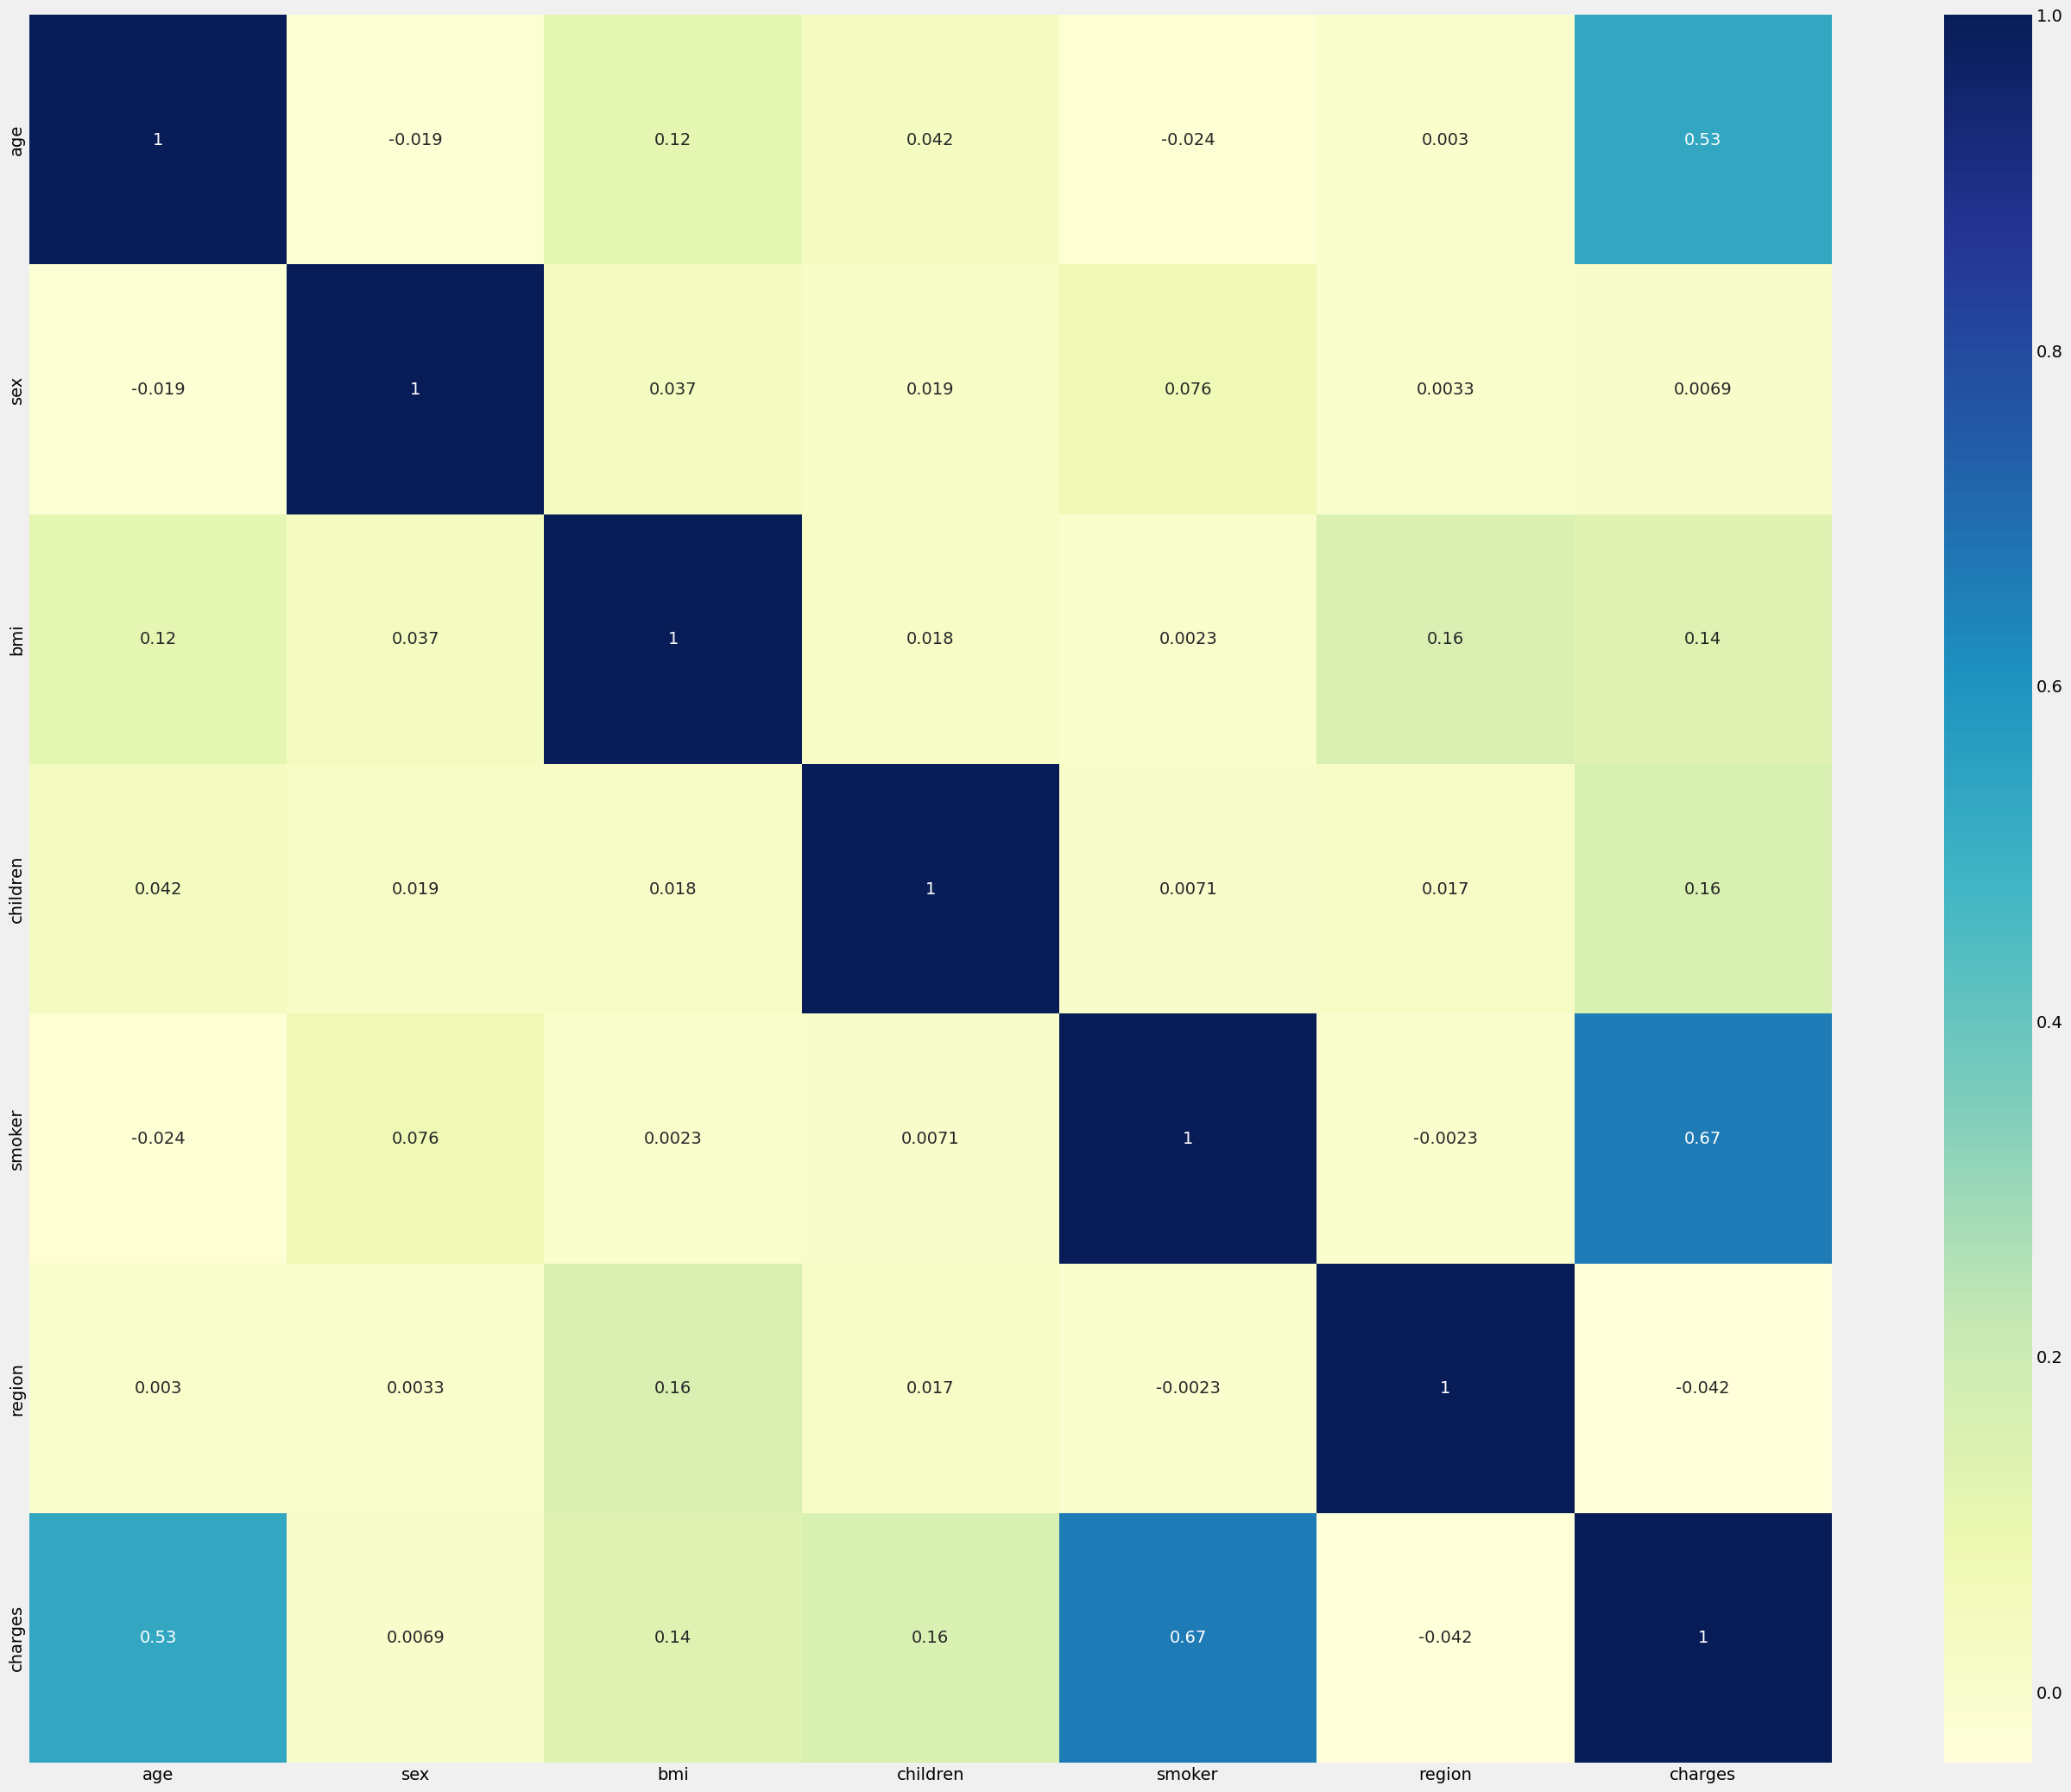

In [41]:
num = data.select_dtypes(include = ['int64', 'float64'])
plt.figure(figsize = (30, 25))
sns.heatmap(num.corr(), annot = True, cmap="YlGnBu")
plt.show()

Regression

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)

In [43]:
lr = LinearRegression()

In [91]:
y_col = "charges"

X = data.drop(y_col, axis=1)
y = data[y_col]

Test Train Split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print("Number of test samples:", X_test.shape[0])
print("Number of training samples:", X_train.shape[0])

Number of test samples: 401
Number of training samples: 933


In [93]:
from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [94]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

print(linearRegression_rmse)

0.4806973054959028


L1 vs L2

In [95]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X_ss = s.fit_transform(X)

In [96]:
from sklearn.linear_model import Ridge, Lasso
### BEGIN SOLUTION
# Part 1

# Decreasing regularization and ensuring convergence
las001 = Lasso(alpha= 0.001, max_iter=100000)

# Transforming training set to get standardized units
X_train_s = s.fit_transform(X_train)

# Fitting model to training set
las001.fit(X_train_s, y_train)

# Transforming test set using the parameters defined from training set
X_test_s = s.transform(X_test)

# Finding prediction on test set
y_pred = las001.predict(X_test_s)

# Calculating r2 score
print("r2 score for alpha = 0.001:", r2_score(y_pred, y_test))


# Part 2

# Using vanilla Linear Regression
lr = LinearRegression()

# Fitting model to training set
lr.fit(X_train_s, y_train)

# predicting on test set
y_pred_lr = lr.predict(X_test_s)

# Calculating r2 score
print("r2 score for Linear Regression:", r2_score(y_pred_lr, y_test))


# Part 3
print('Magnitude of Lasso coefficients:', abs(las001.coef_).sum())
print('Number of coeffients not equal to 0 for Lasso:', (las001.coef_!=0).sum())

print('Magnitude of Linear Regression coefficients:', abs(lr.coef_).sum())
print('Number of coeffients not equal to 0 for Linear Regression:', (lr.coef_!=0).sum())
### END SOLUTION

r2 score for alpha = 0.001: 0.7032213999842025
r2 score for Linear Regression: 0.704362701198225
Magnitude of Lasso coefficients: 1.5434087808021928
Number of coeffients not equal to 0 for Lasso: 6
Magnitude of Linear Regression coefficients: 1.5500871210620955
Number of coeffients not equal to 0 for Linear Regression: 6


Ridge

In [97]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

0.3 0.4806883456113491


R^2 on training  data  0.7672901554365792
R^2 on testing data  0.7659933099320544


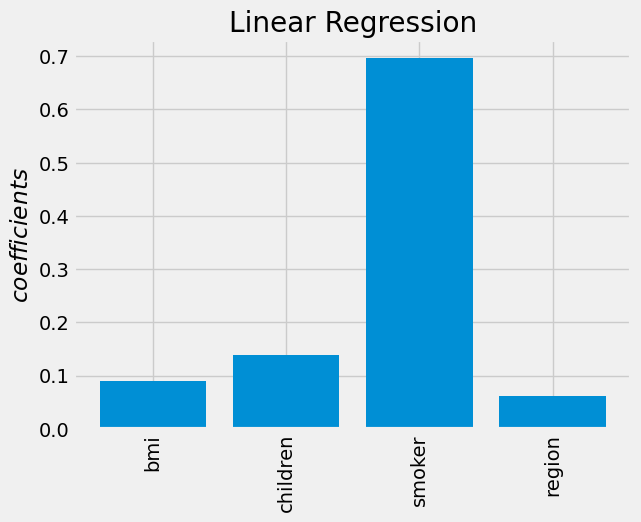

R^2 on training  data  0.7672136341673047
R^2 on testing data  0.7655037288680077


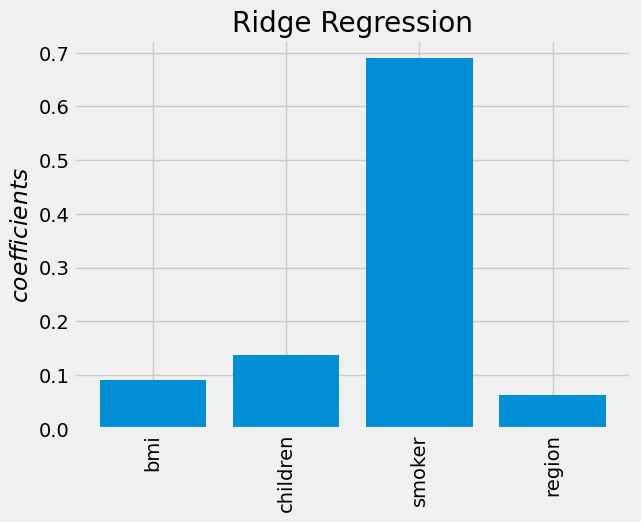

R^2 on training  data  0.7672901554365792
R^2 on testing data  0.7659933099320544


In [98]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)
rr.predict(X_test)

print("R^2 on training  data ",rr.score(X_train, y_train))
print("R^2 on testing data ",rr.score(X_test,y_test))

plot_coef(X,lr,name="Linear Regression")
plot_coef(X,rr,name="Ridge Regression")

Lasso

In [102]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=50000,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower

1e-05 0.48069562656756526


In [103]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), len(lassoCV.coef_.nonzero()[0])))

Of 6 coefficients, 6 are non-zero with Lasso.


Elastic Net

In [104]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2,
                            l1_ratio=l1_ratios,
                            max_iter=10000).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

0.0005 0.1 0.4806766609941872


In [105]:
rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,0.480697
Ridge,0.480688
Lasso,0.480696
ElasticNet,0.480677


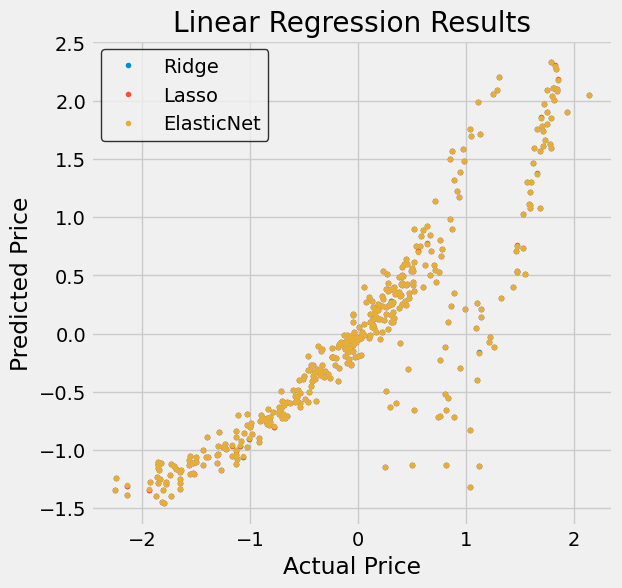

In [106]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'ElasticNet']

models = [ridgeCV, lassoCV, elasticNetCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test),
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price',
       ylabel='Predicted Price',
       title='Linear Regression Results');

Exploring the stochastic gradient

In [107]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': None},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet',
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD
Linear,0.480697,0.481409
Ridge,0.480688,0.855916
Lasso,0.480696,0.480581
ElasticNet,0.480677,0.480939


In [108]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': None},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet',
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7, **parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD-learningrate'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD,RMSE-SGD-learningrate
Linear,0.480697,0.481409,0.993639
Ridge,0.480688,0.855916,0.993693
Lasso,0.480696,0.480581,0.993639
ElasticNet,0.480677,0.480939,0.993639


Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

In [109]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD,RMSE-SGD-learningrate,RMSE-SGD-scaled
Linear,0.480697,0.481409,0.993639,0.496720
Ridge,0.480688,0.855916,0.993693,0.993706
Lasso,0.480696,0.480581,0.993639,0.496551
ElasticNet,0.480677,0.480939,0.993639,0.498273


Polynomial Feature

In [61]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# # Setup the polynomial features
# degree = 20
# pf = PolynomialFeatures(degree)
# lr = LinearRegression()

# # Extract the X- and Y- data from the dataframe
# X_data = X
# Y_data = y

# # Create the features and fit the model
# X_poly = pf.fit_transform(X_data)
# lr = lr.fit(X_poly, Y_data)
# Y_pred = lr.predict(X_poly)

# # Plot the result
# plt.plot(X_data, Y_data, marker='o', ls='', label='data', alpha=1)
# plt.plot(X_real, Y_real, ls='--', label='real function')
# plt.plot(X_data, Y_pred, marker='^', alpha=.5, label='predictions w/ polynomial features')
# plt.legend()
# ax = plt.gca()
# ax.set(xlabel='x data', ylabel='y data');


In [62]:
# # Mute the sklearn warning about regularization
# import warnings
# warnings.filterwarnings('ignore', module='sklearn')

# from sklearn.linear_model import Ridge, Lasso

# # The ridge regression model
# rr = Ridge(alpha=0.001)
# rr = rr.fit(X_poly, Y_data)
# Y_pred_rr = rr.predict(X_poly)

# # The lasso regression model
# lassor = Lasso(alpha=0.0001)
# lassor = lassor.fit(X_poly, Y_data)
# Y_pred_lr = lassor.predict(X_poly)

# # The plot of the predicted values
# plt.plot(X_data, Y_data, marker='o', ls='', label='data')
# plt.plot(X_real, Y_real, ls='--', label='real function')
# plt.plot(X_data, Y_pred, label='linear regression', marker='^', alpha=.5)
# plt.plot(X_data, Y_pred_rr, label='ridge regression', marker='^', alpha=.5)
# plt.plot(X_data, Y_pred_lr, label='lasso regression', marker='^', alpha=.5)

# plt.legend()

# ax = plt.gca()
# ax.set(xlabel='x data', ylabel='y data');

NameError: ignored

In [110]:
# let's look at the absolute value of coefficients for each model

coefficients = pd.DataFrame()
coefficients['linear regression'] = lr.coef_.ravel()
coefficients['ridge regression'] = rr.coef_.ravel()
coefficients['lasso regression'] = lassoCV.coef_.ravel()
coefficients = coefficients.applymap(abs)

coefficients.describe()  # Huge difference in scale between non-regularized vs regularized regression

,linear regression,ridge regression,lasso regression
count,6.000000,6.000000,6.000000
mean,0.258348,0.257665,0.257656
std,0.277513,0.275847,0.275851
min,0.046416,0.046473,0.046462
25%,0.068557,0.069533,0.069521
50%,0.114301,0.113721,0.113711
75%,0.422988,0.424499,0.424495
max,0.695877,0.689177,0.689173


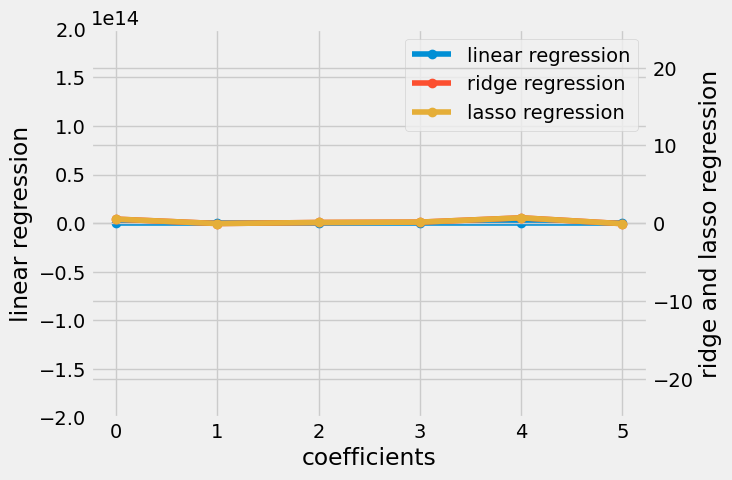

In [111]:
colors = sns.color_palette()

# Setup the dual y-axes
ax1 = plt.axes()
ax2 = ax1.twinx()

# Plot the linear regression data
ax1.plot(lr.coef_.ravel(),
         color=colors[0], marker='o', label='linear regression')

# Plot the regularization data sets
ax2.plot(rr.coef_.ravel(),
         color=colors[1], marker='o', label='ridge regression')

ax2.plot(lassor.coef_.ravel(),
         color=colors[2], marker='o', label='lasso regression')

# Customize axes scales
ax1.set_ylim(-2e14, 2e14)
ax2.set_ylim(-25, 25)

# Combine the legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)

ax1.set(xlabel='coefficients',ylabel='linear regression')
ax2.set(ylabel='ridge and lasso regression')

ax1.set_xticks(range(len(lr.coef_)));

In [73]:
# pf = PolynomialFeatures(degree=2, include_bias=False)
# X= pf.fit_transform(X)

In [74]:
print(type(X))

<class 'numpy.ndarray'>


In [112]:
X.shape[0]

1334

In [113]:
y.shape[0]

1334

Fit `StandardScaler` on `X_train` as before


In [114]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

In [115]:
lr.fit(X_train, y_train)
X_test = s.transform(X_test)
y_pred = lr.predict(X_test)

Model Evaluations

In [116]:
mse = mean_squared_error(y_test, y_pred)
mse

0.23072153435669243

In [117]:
lr.score(X_test,y_test)

0.7663458094848719

In [118]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7663458094848719

In [119]:
print("R^2 on training  data ",lr.score(X_train, y_train))
print("R^2 on testing data ",lr.score(X_test,y_test))

R^2 on training  data  0.7672901555270767
R^2 on testing data  0.7663458094848719


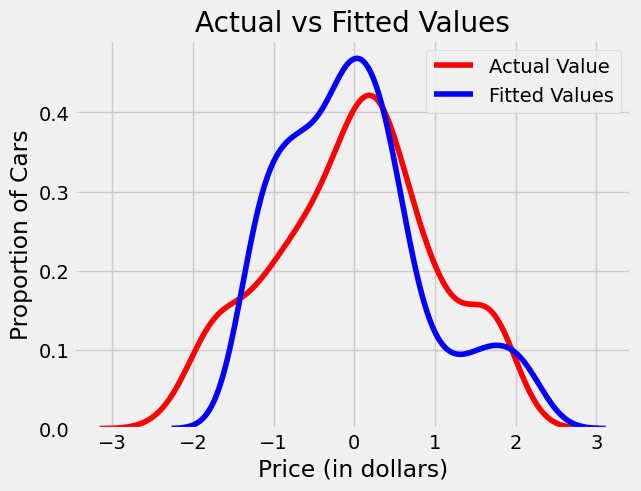

In [120]:
plot_dis(y_test,y_pred)

In [121]:
{col:coef for col,coef in zip(X.columns, lr.coef_)}

{'age': 0.5204480972576477,
 'sex': -0.04647416689554026,
 'bmi': 0.09077368606660051,
 'children': 0.13667127651297245,
 'smoker': 0.6891846075267671,
 'region': -0.06245404896472216}

Pipeline Object

In [122]:
steps=[('scaler', StandardScaler()), ('lr',  LinearRegression())]
pipe = Pipeline(steps=steps)
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [123]:
predicted=pipe.predict(X_test)
pipe.score(X_test, y_test)

0.7663458094848719

In [124]:
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
r2_score(y_pred, y_test)
print(r2_score)

0.4803348148496967
<function r2_score at 0x7f9215482b00>


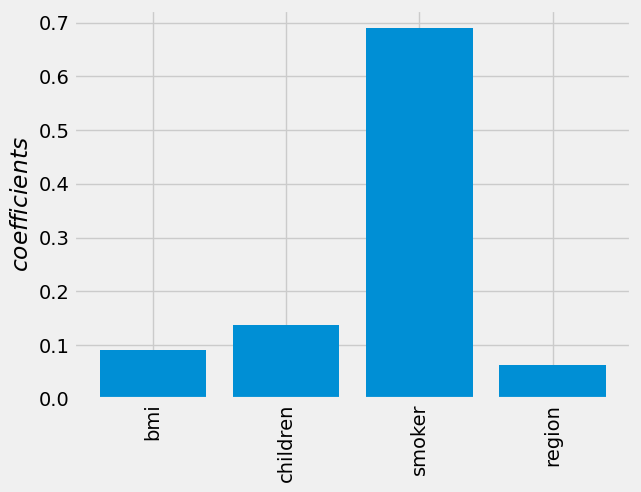

In [125]:
plt.bar(X.columns[2:],abs(lr.coef_[2:]))
plt.xticks(rotation=90)
plt.ylabel("$coefficients$")
plt.show()

In [ ]:
get_R2_features(lr)

Individual Features

In [127]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model', LinearRegression())]

In [128]:
pipe=Pipeline(Input)
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [129]:
print("R^2 on training  data:", pipe.score(X_train, y_train))
print("R^2 on testing data:", pipe.score(X_test,y_test))

R^2 on training  data: 0.8513980287049556
R^2 on testing data: -1.1175556389476819e+18


In [130]:
R_2=[]
pipe = Pipeline([('ss',StandardScaler() ),('lr', LinearRegression())])
features=list(X)
for feature in features:
    pipe.fit(X_train[[feature]],y_train)
    R_2.append(pipe.score(X_train[[feature]],y_train))

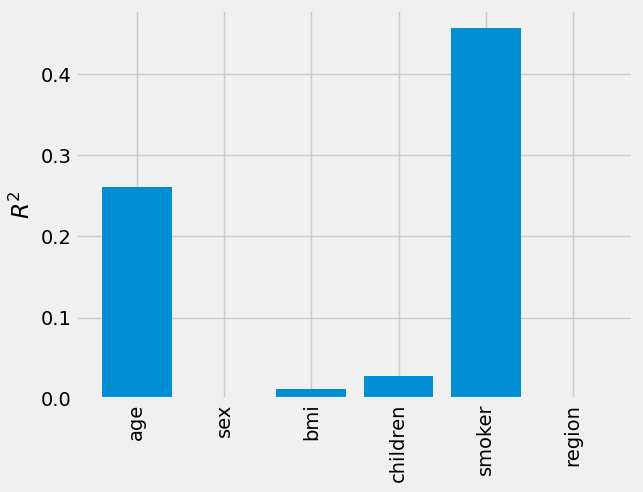

In [131]:
plt.bar(features,R_2)
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.show()

In [132]:
best=features[np.argmax(R_2)]
pipe.fit(X[[best]],y)

Pipeline(steps=[('ss', StandardScaler()), ('lr', LinearRegression())])

In [ ]:
get_R2_features(pipe)

GridSearch and Pipeline

In [134]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',LinearRegression())]
pipe=Pipeline(Input)

In [136]:
param_grid = {
    "polynomial__degree": [1, 2, 3],
    "model__normalize":[True, False],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10]

}

In [137]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipe, param_grid, n_jobs=1)

In [138]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [152]:
# from sklearn.svm import SVC
# model = SVC()
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)
# print(classification_report(y_test, predictions))

ValueError: ignored

In [ ]:
# search = GridSearchCV(pipe, param_grid, n_jobs=2)
# search.fit(X_train, y_train)

# pd.DataFrame(search.cv_results_).head()

In [142]:
# print("best_score_: ",search.best_score_)
# print("best_params_: ",search.best_params_)

AttributeError: ignored

In [ ]:
# predict = search.predict(X_test)
# best=search.best_estimator_
# predict = best.predict(X_test)
# best.score(X_test, y_test)
# best.fit(X,y)

K Fold Cross Validation and score

In [153]:
N=len(X)
lr = LinearRegression()
scores = cross_val_score(lr, X, y, scoring ="r2", cv=3)
def display_scores(scores, print_=False):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())


In [154]:
display_scores(scores)

Scores: [0.75608536 0.79477028 0.72801074]
Mean: 0.7596221284458817
Standard deviation: 0.027368966217725058


In [155]:
scores = cross_val_score(lr, X ,y, scoring ="neg_mean_squared_error", cv=5)
lr_scores = np.sqrt(-scores)
display_scores(lr_scores)

Scores: [0.46750153 0.55877406 0.40166637 0.48313644 0.50498164]
Mean: 0.4832120060290993
Standard deviation: 0.05114695806435784


K_Fold

In [156]:
n_splits=2
kf = KFold(n_splits = n_splits)

In [ ]:
y = data['charges'].copy()
X = data.drop(columns=['charges'])
R_2 = np.zeros((n_splits,1))
pipe = Pipeline([('ss',StandardScaler() ),('lr', LinearRegression())])
n=0
for k,(train_index, test_index) in enumerate(kf.split(X,y)):
    print("TRAIN:", train_index)
    print("TEST:", test_index)
X_train, X_test =X.iloc[train_index],X.iloc[test_index]

y_train, y_test=y[train_index],y[test_index]
pipe.fit(X_train,y_train)
n=+1
R_2[k]=pipe.score(X_test, y_test)

In [158]:
R_2.mean()

0.38636897322275

In [ ]:
n_splits=3
kf = KFold(n_splits = n_splits)
y = data['charges'].copy()
X = data.drop(columns=['charges'])
R_2=np.zeros((n_splits,1))
pipe = Pipeline([('ss',StandardScaler() ),('lr', LinearRegression())])
n=0
for k,(train_index, test_index) in enumerate(kf.split(X,y)):
    print("TRAIN:", train_index)
    print("TEST:", test_index)

X_train, X_test =X.iloc[train_index],X.iloc[test_index]

y_train, y_test=y[train_index],y[test_index]
pipe.fit(X_train,y_train)
n=+1
R_2[k]=pipe.score(X_test, y_test)


R_2.mean()

PCA

In [160]:
scaler = StandardScaler()
X_train[:] = scaler.fit_transform(X_train)
X_train.columns = [f'{c} (scaled)' for c in X_train.columns]

In [162]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

X_train_hat = pca.transform(X_train)
print(X_train_hat.shape)

(890, 6)


In [163]:
X_train_hat_PCA = pd.DataFrame(columns=[f'Projection  on Component {i+1}' for i in range(len(X_train.columns))], data=X_train_hat)
X_train_hat_PCA.head()

,Projection on Component 1,Projection on Component 2,Projection on Component 3,Projection on Component 4,Projection on Component 5,Projection on Component 6
0,-0.635713,1.358839,-1.101771,-1.195317,2.242881,0.241088
1,-0.179535,1.186105,-1.032957,0.842648,-0.484168,-0.734762
2,0.534914,0.883504,0.102212,1.915687,-0.112780,-0.332052
3,-1.687538,0.321669,-0.275573,0.098122,-1.018700,0.562434
4,-0.994466,0.438061,-0.399682,-0.052363,-1.142013,-0.173644


Text(0.5, 1.0, 'Component-wise variance and cumulative explained variance')

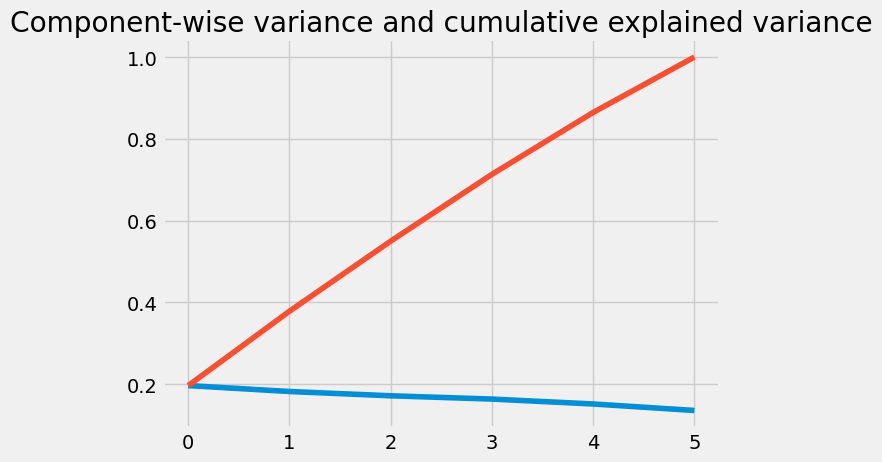

In [164]:
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise variance and cumulative explained variance")

In [167]:
N = 20
X_train_hat_PCA = X_train_hat_PCA.iloc[:, :N]

# enet = elasticNetCV(tol = 0.2, alpha=100, l1_ratio=0.75)
elasticNetCV.fit(X_train_hat_PCA, y_train)

ElasticNetCV(alphas=array([1.e-05, 5.e-05, 1.e-04, 5.e-04]),
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000)